In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
from scipy.stats.mstats import gmean

In [2]:
# get input paths
test_set = "miplib3"
instance_fldr = os.path.join("test_sets", test_set)
results_fldr = os.path.join("results", test_set)
out_fldr = os.path.join("outputs", test_set)

## Check run failures

In [57]:
# running list of strings contained by different error codes
# last two are catchalls
err = {
    "walltime": [],
    "bad_alloc": [],
    "takeoffcuts": [],
    "solver is dual infeasible": [],
    "solver must be optimal": [],
    "segmentation fault": [],
    "no vpcs were made from a new disjunction": [],
    "farkas": [],
    "prlp is primal infeasible": [],  # put outstanding bugs below here
    "must have primalbound > root lp objective": [],
    "objective at parent node": [],
    "failed to optimize mip": [],
    "disjunction does not represent a full binary tree": [],
    "nonbasic reduced cost should be": [],
    "solver not proven optimal for node": [],
    "warning": []
}

# runs that errored out with new error code
other = []

# runs that had no errors
empty = []

# series that didn't run
no_go = []

# counts
count_series = 0
count_instances = 0

# iterate over all expected runs
for instance in os.listdir(instance_fldr):
    if not os.path.isdir(os.path.join(instance_fldr, instance)):
        continue
    for perturbation in os.listdir(os.path.join(instance_fldr, instance)):
        if not os.path.isdir(os.path.join(instance_fldr, instance, perturbation)):
            continue
        for terms in [4, 16, 64]:
            for generator in ["None", "New", "Old", "Farkas"]:

                # set variables for this iteration
                count_series += 1
                stem = f"{instance}_{perturbation}_{terms}_{generator}"
                file_pth = os.path.join(results_fldr, f"{stem}.err")
                series_fldr = os.path.join(instance_fldr, instance, perturbation)
                count_instances += len([f for f in os.listdir(series_fldr) if
                                        f.endswith(".mps")])

                # check if the series wasn't run
                if not os.path.exists(file_pth):
                    no_go.append(stem)
                
                # check if the series ran with no errors or warnings
                elif os.path.getsize(file_pth) == 0:
                    empty.append(stem)
                
                # track which error codes were thrown
                else:
                    # read the file
                    with open(file_pth, "r") as f:
                        text = f.read().lower()
                    
                    # assign the error file to the appropriate list
                    for code in err:
                        if code in text:
                            err[code].append(stem)
                            break
                    else:
                        other.append(stem)

In [58]:
# check which series didn't run
print(no_go)

['10teams_objective_1_4_None', '10teams_objective_1_4_New', '10teams_objective_1_4_Old', '10teams_objective_1_4_Farkas', '10teams_objective_1_16_New', '10teams_objective_1_16_Old', '10teams_objective_1_16_Farkas', '10teams_objective_1_64_New', '10teams_objective_1_64_Old', '10teams_matrix_1_4_New', '10teams_matrix_1_4_Old', '10teams_matrix_1_16_None', '10teams_matrix_1_16_Farkas', '10teams_matrix_1_64_None', '10teams_matrix_1_64_New', '10teams_matrix_1_64_Farkas', '10teams_matrix_0_4_New', '10teams_matrix_0_4_Old', '10teams_matrix_0_4_Farkas', '10teams_matrix_0_16_None', '10teams_matrix_0_16_New', '10teams_matrix_0_16_Old', '10teams_matrix_0_64_None', '10teams_matrix_0_64_New', '10teams_matrix_0_64_Old', '10teams_matrix_0_64_Farkas', '10teams_objective_-1_4_None', '10teams_objective_-1_4_New', '10teams_objective_-1_4_Old', '10teams_objective_-1_16_None', '10teams_objective_-1_16_New', '10teams_objective_-1_16_Farkas', '10teams_objective_-1_64_New', '10teams_objective_-1_64_Farkas', '10

In [59]:
# get the proportion of series that at least got started
1 - (len(no_go) / count_series)

0.7252321981424148

In [60]:
# out of time - rerun with more time if a lot of these
err["walltime"]

['mas74_rhs_1_64_New',
 'mas74_rhs_-1_64_New',
 'qnet1_rhs_0_16_Old',
 'qnet1_matrix_0_4_Old',
 'qnet1_matrix_0_16_Old',
 'qnet1_matrix_0_16_Farkas',
 'qnet1_matrix_-1_16_Old',
 'qnet1_matrix_-1_16_Farkas',
 'pp08aCUTS_objective_-1_64_New',
 'pp08aCUTS_objective_-1_64_Old',
 'mitre_matrix_1_4_Old',
 'mitre_matrix_0_4_New',
 'mitre_objective_0_4_New',
 'mitre_matrix_-1_4_New',
 'p0282_objective_1_64_New',
 'p0282_objective_0_64_New',
 'p0282_objective_-1_16_New',
 'p0282_objective_-1_64_New']

In [61]:
# out of memory - rerun with more memory if a lot of these
err["bad_alloc"]

['mitre_objective_1_4_Old',
 'mitre_objective_1_4_Farkas',
 'mitre_matrix_0_4_Old',
 'mitre_matrix_0_4_Farkas',
 'mitre_matrix_-1_4_Old',
 'mitre_matrix_-1_4_Farkas',
 'mitre_objective_-1_4_Old',
 'mitre_objective_-1_4_Farkas',
 'mitre_bound_0_4_Old',
 'mitre_bound_0_4_Farkas',
 'l152lav_rhs_0_16_Old',
 'l152lav_matrix_1_16_Old',
 'l152lav_matrix_1_16_Farkas',
 'l152lav_objective_0_16_Farkas',
 'l152lav_rhs_-1_16_Farkas',
 'p0282_matrix_0_64_Farkas',
 'p0282_matrix_-1_64_Farkas',
 'misc07_matrix_-1_64_Old',
 'misc07_matrix_-1_64_Farkas']

In [62]:
# this is an issue with John's bookkeeping - not much we can do here
err["takeoffcuts"]

['blend2_rhs_-1_4_Old',
 'blend2_matrix_-1_16_Old',
 'mitre_objective_1_4_New',
 'mitre_matrix_1_4_New',
 'mitre_objective_0_4_Old',
 'mitre_objective_0_4_Farkas',
 'mitre_objective_-1_4_New',
 'mitre_bound_0_4_New',
 'bell5_matrix_0_4_Farkas',
 'p0033_matrix_1_4_Old',
 'p0033_matrix_1_4_Farkas',
 'p0033_matrix_1_16_Old',
 'p0033_matrix_0_4_Old',
 'p0033_matrix_0_4_Farkas',
 'p0033_matrix_0_16_Farkas',
 'p0033_objective_0_16_Old',
 'pp08a_matrix_0_64_New']

In [63]:
err["solver is dual infeasible"]

[]

In [64]:
# these are usually issues with CLP finding optimality - not much we can do here
err["solver must be optimal"]

['qnet1_o_bound_1_4_New',
 'qnet1_o_bound_1_4_Old',
 'qnet1_o_bound_1_4_Farkas',
 'qnet1_o_bound_1_16_Old',
 'qnet1_bound_1_4_New',
 'qnet1_bound_1_4_Old',
 'qnet1_bound_1_4_Farkas',
 'qnet1_bound_1_16_New',
 'qnet1_bound_1_16_Old',
 'qnet1_bound_1_16_Farkas',
 'pp08aCUTS_objective_1_4_New',
 'pp08aCUTS_objective_1_4_Old',
 'pp08aCUTS_objective_1_4_Farkas',
 'pp08aCUTS_objective_1_16_New',
 'pp08aCUTS_objective_1_16_Old',
 'pp08aCUTS_objective_1_16_Farkas',
 'pp08aCUTS_objective_1_64_New',
 'pp08aCUTS_objective_1_64_Old',
 'pp08aCUTS_objective_1_64_Farkas',
 'pp08aCUTS_objective_0_4_New',
 'pp08aCUTS_objective_0_4_Old',
 'pp08aCUTS_objective_0_4_Farkas',
 'pp08aCUTS_objective_0_16_New',
 'pp08aCUTS_objective_0_16_Old',
 'pp08aCUTS_objective_0_16_Farkas',
 'pp08aCUTS_objective_0_64_New',
 'pp08aCUTS_objective_0_64_Old',
 'pp08aCUTS_objective_0_64_Farkas',
 'pp08a_objective_0_16_New',
 'pp08a_objective_0_16_Old']

In [65]:
err["segmentation fault"]

[]

In [66]:
# these should all be from the problem being too big and hitting the time limit
err["no vpcs were made from a new disjunction"]

['qnet1_o_matrix_1_64_New',
 'qnet1_o_matrix_1_64_Old',
 'qnet1_o_matrix_1_64_Farkas',
 'qnet1_o_matrix_0_64_New',
 'qnet1_o_matrix_0_64_Old',
 'qnet1_o_matrix_0_64_Farkas',
 'qnet1_o_matrix_-1_64_New',
 'qnet1_o_matrix_-1_64_Old',
 'qnet1_o_matrix_-1_64_Farkas',
 'qnet1_o_bound_1_64_New',
 'qnet1_o_bound_1_64_Old',
 'qnet1_o_bound_1_64_Farkas',
 'qnet1_rhs_0_64_New',
 'qnet1_rhs_0_64_Old',
 'qnet1_rhs_0_64_Farkas',
 'qnet1_rhs_1_64_New',
 'qnet1_rhs_1_64_Old',
 'qnet1_rhs_1_64_Farkas',
 'qnet1_matrix_1_64_New',
 'qnet1_matrix_1_64_Old',
 'qnet1_matrix_1_64_Farkas',
 'qnet1_matrix_0_64_New',
 'qnet1_matrix_0_64_Old',
 'qnet1_matrix_0_64_Farkas',
 'qnet1_matrix_-1_64_New',
 'qnet1_matrix_-1_64_Old',
 'qnet1_matrix_-1_64_Farkas',
 'qnet1_bound_1_64_New',
 'qnet1_bound_1_64_Old',
 'qnet1_bound_1_64_Farkas',
 'mitre_objective_1_16_New',
 'mitre_objective_1_16_Old',
 'mitre_objective_1_16_Farkas',
 'mitre_objective_1_64_New',
 'mitre_objective_1_64_Old',
 'mitre_objective_1_64_Farkas',
 'mi

In [67]:
# this may be a bug in my code - track down if a lot
err["farkas"]

['blend2_matrix_0_4_New',
 'blend2_matrix_0_16_New',
 'blend2_matrix_-1_4_New',
 'blend2_matrix_-1_16_New',
 'rentacar_objective_1_4_Old',
 'rentacar_objective_1_4_Farkas',
 'rentacar_objective_-1_4_Farkas',
 'pp08aCUTS_matrix_-1_16_New',
 'p0282_objective_0_16_New']

In [68]:
# this shouldn't be an issue - effected runs just get skipped
err["prlp is primal infeasible"]

['blend2_matrix_1_4_Old',
 'blend2_matrix_1_16_Old',
 'blend2_matrix_0_4_Old',
 'blend2_matrix_0_16_Old',
 'blend2_matrix_-1_4_Old',
 'modglob_matrix_1_4_Old',
 'modglob_matrix_1_16_Old',
 'modglob_matrix_0_4_Old',
 'modglob_matrix_0_16_Old',
 'modglob_matrix_0_64_Old',
 'qnet1_o_matrix_1_4_Old',
 'qnet1_o_matrix_1_16_Old',
 'qnet1_o_matrix_0_4_Old',
 'mas74_rhs_0_4_New',
 'mas74_rhs_0_4_Old',
 'mas74_rhs_0_16_New',
 'mas74_rhs_0_16_Old',
 'mas74_rhs_0_64_New',
 'mas74_rhs_0_64_Old',
 'mas74_matrix_1_4_New',
 'mas74_matrix_1_4_Old',
 'mas74_matrix_1_16_New',
 'mas74_matrix_1_16_Old',
 'mas74_matrix_1_64_New',
 'mas74_matrix_1_64_Old',
 'mas74_matrix_0_4_New',
 'mas74_matrix_0_4_Old',
 'mas74_matrix_0_16_New',
 'mas74_matrix_0_16_Old',
 'mas74_matrix_0_64_New',
 'mas74_matrix_0_64_Old',
 'mas74_matrix_-1_4_Old',
 'mas74_matrix_-1_16_New',
 'mas74_matrix_-1_16_Old',
 'mas74_matrix_-1_64_New',
 'mas74_matrix_-1_64_Old',
 'qnet1_matrix_1_4_Old',
 'qnet1_matrix_-1_4_Old',
 'pp08aCUTS_matrix

In [69]:
err["warning"]

['modglob_matrix_0_16_New', 'p0033_rhs_0_16_New']

In [70]:
# issue was not optimizing solver before checking LP relaxation objective vs primal bound
err["must have primalbound > root lp objective"]

['blend2_objective_1_4_None',
 'blend2_objective_1_4_New',
 'blend2_objective_1_4_Old',
 'blend2_objective_1_4_Farkas',
 'blend2_objective_1_16_None',
 'blend2_objective_1_16_New',
 'blend2_objective_1_16_Old',
 'blend2_objective_1_16_Farkas',
 'blend2_objective_1_64_None',
 'cap6000_objective_1_4_None',
 'cap6000_objective_1_4_New',
 'cap6000_objective_1_4_Old',
 'cap6000_objective_1_4_Farkas',
 'cap6000_objective_1_16_None',
 'cap6000_objective_1_16_New',
 'cap6000_objective_1_16_Old',
 'cap6000_objective_1_16_Farkas',
 'cap6000_objective_1_64_None',
 'cap6000_objective_1_64_New',
 'cap6000_objective_1_64_Old',
 'cap6000_objective_1_64_Farkas',
 'cap6000_matrix_0_4_None',
 'cap6000_matrix_0_4_New',
 'cap6000_matrix_0_4_Old',
 'cap6000_matrix_0_4_Farkas',
 'cap6000_matrix_0_16_None',
 'cap6000_matrix_0_16_New',
 'cap6000_matrix_0_16_Old',
 'cap6000_matrix_0_16_Farkas',
 'cap6000_matrix_0_64_None',
 'cap6000_matrix_0_64_New',
 'cap6000_matrix_0_64_Old',
 'cap6000_matrix_0_64_Farkas',
 

In [71]:
# LP relxation objective is not going to match root node objective when warm starting 
err["objective at parent node"]

['blend2_rhs_0_4_New',
 'blend2_rhs_0_4_Old',
 'blend2_rhs_0_4_Farkas',
 'blend2_rhs_0_16_New',
 'blend2_rhs_0_16_Old',
 'blend2_rhs_0_16_Farkas',
 'blend2_rhs_0_64_New',
 'blend2_rhs_0_64_Old',
 'blend2_rhs_0_64_Farkas',
 'blend2_objective_1_64_New',
 'blend2_objective_1_64_Old',
 'blend2_objective_1_64_Farkas',
 'blend2_matrix_1_4_New',
 'blend2_matrix_1_4_Farkas',
 'blend2_matrix_1_16_New',
 'blend2_matrix_1_16_Farkas',
 'blend2_matrix_1_64_New',
 'blend2_matrix_1_64_Old',
 'blend2_matrix_1_64_Farkas',
 'blend2_matrix_0_4_Farkas',
 'blend2_matrix_0_16_Farkas',
 'blend2_matrix_0_64_New',
 'blend2_matrix_0_64_Old',
 'blend2_matrix_0_64_Farkas',
 'blend2_rhs_-1_4_New',
 'blend2_rhs_-1_4_Farkas',
 'blend2_rhs_-1_16_New',
 'blend2_rhs_-1_16_Old',
 'blend2_rhs_-1_16_Farkas',
 'blend2_rhs_-1_64_New',
 'blend2_rhs_-1_64_Old',
 'blend2_rhs_-1_64_Farkas',
 'blend2_matrix_-1_4_Farkas',
 'blend2_matrix_-1_16_Farkas',
 'blend2_matrix_-1_64_New',
 'blend2_matrix_-1_64_Old',
 'blend2_matrix_-1_64_

In [72]:
# not enough tolerance added to bound
err["failed to optimize mip"]

['qnet1_o_matrix_0_16_New',
 'qnet1_o_matrix_0_16_Old',
 'qnet1_o_matrix_0_16_Farkas',
 'qnet1_o_matrix_-1_16_New',
 'qnet1_o_matrix_-1_16_Old',
 'qnet1_o_matrix_-1_16_Farkas',
 'qnet1_o_bound_1_16_New',
 'qnet1_o_bound_1_16_Farkas',
 'rentacar_objective_1_4_None',
 'rentacar_objective_1_4_New',
 'rentacar_objective_1_16_None',
 'rentacar_objective_1_16_New',
 'rentacar_objective_1_16_Old',
 'rentacar_objective_1_16_Farkas',
 'rentacar_objective_1_64_None',
 'rentacar_objective_1_64_New',
 'rentacar_objective_1_64_Old',
 'rentacar_objective_1_64_Farkas',
 'rentacar_objective_0_4_None',
 'rentacar_objective_0_4_New',
 'rentacar_objective_0_4_Old',
 'rentacar_objective_0_4_Farkas',
 'rentacar_objective_0_16_None',
 'rentacar_objective_0_16_New',
 'rentacar_objective_0_16_Old',
 'rentacar_objective_0_16_Farkas',
 'rentacar_objective_0_64_None',
 'rentacar_objective_0_64_New',
 'rentacar_objective_0_64_Old',
 'rentacar_objective_0_64_Farkas',
 'rentacar_objective_-1_4_None',
 'rentacar_obj

In [73]:
err["disjunction does not represent a full binary tree"]

['bell5_matrix_0_16_Old', 'bell5_matrix_0_16_Farkas']

In [74]:
# this and next issue I think are because we run out of time creating tree leading to errors
err["nonbasic reduced cost should be"]

['air04_objective_1_4_New',
 'air04_objective_1_4_Old',
 'air04_objective_1_4_Farkas',
 'air04_matrix_1_4_New',
 'air04_matrix_1_4_Old',
 'air04_matrix_1_4_Farkas',
 'air04_matrix_0_4_New',
 'air04_matrix_0_4_Old',
 'air04_matrix_0_4_Farkas',
 'air04_objective_0_4_New',
 'air04_objective_0_4_Old',
 'air04_objective_0_4_Farkas',
 'air04_matrix_-1_4_New',
 'air04_matrix_-1_4_Old',
 'air04_matrix_-1_4_Farkas',
 'air04_objective_-1_4_New',
 'air04_objective_-1_4_Old',
 'air04_objective_-1_4_Farkas',
 'air04_bound_0_4_New',
 'air04_bound_0_4_Old',
 'air04_bound_0_4_Farkas',
 'air04_bound_1_4_New',
 'air04_bound_1_4_Old',
 'air04_bound_1_4_Farkas',
 'air05_objective_1_4_New',
 'air05_objective_1_4_Old',
 'air05_objective_1_4_Farkas',
 'air05_matrix_1_4_New',
 'air05_matrix_1_4_Old',
 'air05_matrix_1_4_Farkas',
 'air05_matrix_0_4_New',
 'air05_matrix_0_4_Old',
 'air05_matrix_0_4_Farkas',
 'air05_objective_0_4_New',
 'air05_objective_0_4_Old',
 'air05_objective_0_4_Farkas',
 'air05_matrix_-1_4

In [75]:
err["solver not proven optimal for node"]

['air04_objective_1_16_New',
 'air04_objective_1_16_Old',
 'air04_objective_1_16_Farkas',
 'air04_objective_1_64_New',
 'air04_objective_1_64_Old',
 'air04_objective_1_64_Farkas',
 'air04_matrix_1_16_New',
 'air04_matrix_1_16_Old',
 'air04_matrix_1_16_Farkas',
 'air04_matrix_1_64_New',
 'air04_matrix_1_64_Old',
 'air04_matrix_1_64_Farkas',
 'air04_matrix_0_16_New',
 'air04_matrix_0_16_Old',
 'air04_matrix_0_16_Farkas',
 'air04_matrix_0_64_New',
 'air04_matrix_0_64_Old',
 'air04_matrix_0_64_Farkas',
 'air04_objective_0_16_New',
 'air04_objective_0_16_Old',
 'air04_objective_0_16_Farkas',
 'air04_objective_0_64_New',
 'air04_objective_0_64_Old',
 'air04_objective_0_64_Farkas',
 'air04_matrix_-1_16_New',
 'air04_matrix_-1_16_Old',
 'air04_matrix_-1_16_Farkas',
 'air04_matrix_-1_64_New',
 'air04_matrix_-1_64_Old',
 'air04_matrix_-1_64_Farkas',
 'air04_objective_-1_16_New',
 'air04_objective_-1_16_Old',
 'air04_objective_-1_16_Farkas',
 'air04_objective_-1_64_New',
 'air04_objective_-1_64_O

In [76]:
# errors unaccounted for
other

[]

In [18]:
# proportion of series that had no critical issues
len(empty + err["warning"] + err["prlp is primal infeasible"] + err["walltime"]) / count_series

0.47781217750258

In [19]:
# proportion of series that had no critical issues broken down by generator
for generator in ["None", "New", "Old", "Farkas"]:
    g = [s for s in empty + err["warning"] + err["prlp is primal infeasible"] + err["walltime"] if s.endswith(generator)]
    print(f"{generator}: {4 * len(g) / count_series}")

None: 0.5789473684210527
New: 0.41279669762641896
Old: 0.45923632610939114
Farkas: 0.4602683178534572


In [20]:
# proportion of series that were improperly provisioned
(len(err["bad_alloc"] + err["walltime"])) / count_series

0.009545923632610939

## Read in data

In [21]:
# map generator names to the corresponding data frames
df_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
gap_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
regex = re.compile(r'([a-zA-Z0-9-]+)_([a-z]+)_([0-9-]+)_([0-9]+)_([a-zA-Z ]+)')

# iterate over all files in the folder
for file_name in os.listdir(results_fldr):
    
    file_pth = os.path.join(results_fldr, file_name)
    
    # if the file is not a nonempty csv, skip it
    if not file_name.endswith(".csv") or os.path.getsize(file_pth) == 0:
        continue
    
    # get the experimental set up
    match = regex.search(file_name)
    instance_name = match.group(1)
    perturbation = match.group(2)
    degree = 2**int(match.group(3))
    terms = int(match.group(4))
    generator = match.group(5)
    
    # read the file
    df = pd.read_csv(file_pth, keep_default_na=False)
    
    # add some identifying columns
    df["instance"] = instance_name
    df["perturbation"] = perturbation
    df["degree"] = degree
    df["terms"] = terms
    
    # append to the appropriate data frame
    if not file_name.endswith("bound.csv"):
        df_map[generator] = pd.concat([df_map[generator], df])
    else:
        df["times"] = df["times"].astype(int) 
        df = df[~df.duplicated(subset=['times', "instanceIndex", "perturbation", "degree", "terms"], keep='last')]
        df = df.rename(columns={'primalBounds': 'primalBound', 'dualBounds': 'dualBound'})
        gap_map[generator] = pd.concat([gap_map[generator], df])

In [22]:
# get proportion of instances run
for generator, df in df_map.items():
    print(f"{generator}: {4 * len(df) / count_instances}")

None: 0.24948805460750853
Farkas: 0.11501706484641638
New: 0.0695108077360637
Old: 0.09283276450511946


In [23]:
gen = "Farkas" # make sure masks 3 and 9 are fixed rest should be fine
masks = {
        0: -1e20 > df_map[gen]["lpBound"],
        1: df_map[gen]["lpBound"] - 1e-4 > df_map[gen]["lpBoundPostVpc"],
        2: df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["disjunctiveDualBound"],
        3: df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["rootDualBound"],
        4: df_map[gen]["rootDualBound"] - 1e-4 > df_map[gen]["dualBound"],
        5: df_map[gen]["dualBound"] - 1e-4 > df_map[gen]["primalBound"],
        6: df_map[gen]["primalBound"] > 1e20,
        7: 0 > df_map[gen]["vpcGenerationTime"],
        8: df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["rootDualBoundTime"],
        9: df_map[gen]["rootDualBoundTime"] - 1e-4 > df_map[gen]["terminationTime"],
        10: 0 > df_map[gen]["vpcGenerationTime"],
        11: df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["bestSolutionTime"],
        12: df_map[gen]["bestSolutionTime"] - 1e-4 > df_map[gen]["terminationTime"],
        13: df_map[gen]["terminationTime"] > df_map[gen]["maxTime"] + 10
    }

df_map[gen][masks[0]]

TypeError: '>' not supported between instances of 'float' and 'str'

In [60]:
for gen in df_map:
    mask = (-1e20 > df_map[gen]["lpBound"]) | \
        (df_map[gen]["lpBound"] - 1e-4 > df_map[gen]["lpBoundPostVpc"]) | \
        (df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["disjunctiveDualBound"]) | \
        (df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["rootDualBound"]) | \
        (df_map[gen]["rootDualBound"] - 1e-4 > df_map[gen]["dualBound"]) | \
        (df_map[gen]["dualBound"] - 1e-4 > df_map[gen]["primalBound"]) | \
        (df_map[gen]["primalBound"] > 1e20) | \
        (0 > df_map[gen]["vpcGenerationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["heuristicTime"]) | \
        (df_map[gen]["heuristicTime"] - 1e-4 > df_map[gen]["rootDualBoundTime"]) | \
        (df_map[gen]["rootDualBoundTime"] - 1e-4 > df_map[gen]["terminationTime"]) | \
        (0 > df_map[gen]["firstSolutionTime"]) | \
        (df_map[gen]["firstSolutionTime"] - 1e-4 > df_map[gen]["bestSolutionTime"]) | \
        (df_map[gen]["bestSolutionTime"] - 1e-4 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["terminationTime"] > df_map[gen]["maxTime"] + 10) | \
        (df_map[gen]["vpcGenerationTime"] > df_map[gen]["maxTime"])
    df_map[gen] = df_map[gen][~mask]

In [87]:
# merge the 4 different data frames into one
join_cols = ["instance", "perturbation", "degree", "terms", "instanceIndex"]
df = df_map["None"].merge(df_map["New"], on=join_cols,
                                suffixes=(" None", None))
df = df.merge(df_map["Old"], on=join_cols,
                          suffixes=(" New", None))
df = df.merge(df_map["Farkas"], on=join_cols,
                          suffixes=(" Old", " Farkas"))
df

,instanceIndex None,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,heuristicPrimalBound None,primalBound None,vpcGenerationTime None,heuristicTime None,...,heuristicTime Farkas,rootDualBoundTime Farkas,firstSolutionTime Farkas,bestSolutionTime Farkas,terminationTime Farkas,maxTime Farkas,vpcGenerator Farkas,iterations Farkas,nodes Farkas,actualTerms Farkas
0,0,134.915590,134.915590,134.915590,143.653501,146.628278,154.0,149.0,0.095830,1.203077,...,4.569674,7.554979,4.569686,12.151268,509.629356,1200.0,New,302628,12349,4
1,1,135.862243,135.862243,135.862243,144.515640,147.511512,153.0,149.0,0.090988,1.008871,...,1.171203,4.456548,1.171216,4.559643,1093.147154,1200.0,Farkas,562278,26480,4
2,2,135.354844,135.354844,135.354844,143.841106,147.348929,152.0,150.0,0.092704,1.051885,...,1.241280,4.391223,1.241297,391.629620,1071.292212,1200.0,Farkas,459992,32054,4
3,3,135.311224,135.311224,135.311224,142.730884,146.818088,151.0,148.0,0.099733,1.708531,...,1.874567,5.445036,1.874585,623.514180,1053.655712,1200.0,Farkas,517599,28480,4
4,4,134.405958,134.405958,134.405958,141.990942,145.020990,153.0,146.0,0.087438,1.685073,...,1.847983,4.433785,1.847997,5.054658,701.614764,1200.0,Farkas,360563,16151,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,1,135.862243,135.862243,135.862243,144.515640,147.510937,153.0,149.0,0.091914,1.034288,...,5.124678,8.304932,5.124705,485.702021,1076.641824,1200.0,Farkas,521900,24276,78
910,2,135.354844,135.354844,135.354844,143.841106,147.358045,152.0,150.0,0.090282,1.048257,...,5.153648,8.624632,5.153661,40.374461,1200.590446,1200.0,Farkas,545052,32248,78
911,3,135.311224,135.311224,135.311224,142.730884,146.818088,151.0,148.0,0.091432,1.688212,...,5.731052,7.781497,5.731067,37.033789,455.856131,1200.0,Farkas,247541,13019,78
912,4,134.405958,134.405958,134.405958,141.990942,145.020990,153.0,146.0,0.086942,1.664938,...,5.697531,9.030937,5.697542,241.251500,301.538990,1200.0,Farkas,173042,11048,78


In [88]:
# get proportion of tests run
4 * len(df) / count_instances

0.5317044793484584

In [89]:
def gap_closed(df, col):
    gap = (df[col] - df["lpBound None"]) / (df['primalBound None'] - df["lpBound None"])
    gap[(gap < 0) | (gap > 1)] = np.nan
    return gap

In [90]:
# find the optimality gap closed by each generator
df["Disjunction (New)"] = gap_closed(df, "disjunctiveDualBound New")
df["Disjunction (Old)"] = gap_closed(df, "disjunctiveDualBound Old")
df["VPCs (New)"] = gap_closed(df, "lpBoundPostVpc New")
df["VPCs (Old)"] = gap_closed(df, "lpBoundPostVpc Old")
df["VPCs (Farkas)"] = gap_closed(df, "lpBoundPostVpc Farkas")
df["Root Cuts (None)"] = gap_closed(df, "rootDualBound None")
df["Root Cuts (New)"] = gap_closed(df, "rootDualBound New")
df["Root Cuts (Old)"] = gap_closed(df, "rootDualBound Old")
df["Root Cuts (Farkas)"] = gap_closed(df, "rootDualBound Farkas")
df = df.dropna()

In [91]:
# set aside core columns and filter for all subsequent dataframes
group_cols = ["instance", "perturbation", "degree", "terms"]
id_cols = ["instanceIndex"]
mask = (df["instanceIndex"] > 0) & (df["Disjunction (New)"] < .9999)

## Make bound table

In [92]:
# additional filtering for dataframe on bounds
fields = ["Disjunction (New)", "Disjunction (Old)", "VPCs (New)", "VPCs (Old)",
          "VPCs (Farkas)", "Root Cuts (None)", "Root Cuts (New)", "Root Cuts (Old)",
          "Root Cuts (Farkas)"]
bound_df = df.loc[mask, group_cols + id_cols + fields]
bound_df

,instance,perturbation,degree,terms,problem number,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),Root Cuts (Farkas)
1,neos-3610173-itata,rhs,2.0,4,1,0.095260,0.067357,0.000000,0.024850,0.024850,0.658666,0.645240,0.675501,0.669352
2,neos-3610173-itata,rhs,2.0,4,2,0.169384,0.062536,0.000000,0.008756,0.023759,0.579459,0.591980,0.577645,0.700866
3,neos-3610173-itata,rhs,2.0,4,3,0.072573,0.086613,0.000000,0.027092,0.027092,0.584742,0.671195,0.591480,0.614325
4,neos-3610173-itata,rhs,2.0,4,4,0.077359,0.076236,0.003720,0.020341,0.020341,0.654214,0.669322,0.677505,0.675238
5,neos-3610173-itata,rhs,2.0,4,5,0.114146,0.081629,0.013967,0.026777,0.026777,0.677859,0.689113,0.628410,0.629432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,neos-3610173-itata,rhs,2.0,64,1,0.267664,0.288739,0.007663,0.003500,0.034941,0.658666,0.625499,0.610663,0.695137
910,neos-3610173-itata,rhs,2.0,64,2,0.341213,0.225384,0.044887,0.000000,0.003785,0.579459,0.600479,0.616522,0.621531
911,neos-3610173-itata,rhs,2.0,64,3,0.329821,0.298938,0.005659,0.009216,0.037684,0.584742,0.564289,0.635940,0.565855
912,neos-3610173-itata,rhs,2.0,64,4,0.285463,0.322308,0.167155,0.000000,0.035065,0.654214,0.549041,0.592577,0.791990


In [93]:
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

In [94]:
# get gap closed by degree and term
out = bound_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table.csv"), index=False, mode="w")
out

,degree,terms,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),Root Cuts (Farkas),instance,problem number
0,0.5,4,0.094807,0.073996,0.082235,0.063782,0.048994,0.260764,0.264885,0.266981,0.262648,5,55
1,0.5,16,0.263627,0.225217,0.192924,0.148013,0.164600,0.286840,0.342372,0.320517,0.324645,5,50
2,0.5,64,0.486110,0.452069,0.360990,0.269726,0.268943,0.328771,0.479322,0.452957,0.445440,5,39
3,1.0,4,0.115875,0.090129,0.061061,0.056117,0.048033,0.407567,0.428886,0.415839,0.407611,11,100
4,1.0,16,0.262093,0.250297,0.151821,0.138277,0.129055,0.438567,0.485695,0.480805,0.473748,11,92
5,1.0,64,0.399248,0.378404,0.230958,0.187997,0.154196,0.467992,0.553302,0.547030,0.550455,10,72
6,2.0,4,0.096608,0.082099,0.048228,0.045018,0.035158,0.389485,0.400150,0.399548,0.393401,11,127
7,2.0,16,0.250957,0.222319,0.120324,0.115633,0.101541,0.442883,0.474289,0.467206,0.453794,11,104
8,2.0,64,0.300542,0.276275,0.139560,0.129277,0.073967,0.445289,0.492736,0.476209,0.472174,10,80


In [95]:
# now break it down by type of perturbation
bound_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations)

Disjunction (New)  Disjunction (Old)  VPCs (New)  \
degree terms perturbation                                                     
0.5    4     matrix                 0.081090           0.062902    0.083133   
             objective              0.160803           0.141988    0.125120   
             rhs                    0.065544           0.036835    0.040575   
       16    matrix                 0.224616           0.186852    0.198716   
             objective              0.502614           0.461476    0.310159   
             rhs                    0.118045           0.080909    0.073567   
       64    matrix                 0.500093           0.465246    0.447554   
             objective              0.704425           0.681959    0.438084   
             rhs                    0.200363           0.153801    0.121317   
1.0    4     matrix                 0.112708           0.080888    0.060350   
             objective              0.188514           0.149107    0.119963   
             rhs                    0.102443           0.086515    0.048140   
       16    matrix                 0.237539           0.228053    0.133810   
             objective              0.539778           0.466755    0.259295   
             rhs                    0.216333           0.218593    0.144981   
       64    matrix                 0.397984           0.387808    0.260244   
             objective              0.713491           0.645438    0.386087   
             rhs                    0.284501           0.267311    0.135539   
2.0    4     matrix                 0.091673           0.069285    0.045226   
             objective              0.138895           0.105609    0.076792   
             rhs                    0.091036           0.090004    0.044102   
       16    matrix                 0.259172           0.207099    0.106763   
             objective              0.383859           0.315870    0.166643   
             rhs                    0.203853           0.208378    0.118933   
       64    matrix                 0.325536           0.298967    0.144276   
             objective              0.424640           0.393088    0.149347   
             rhs                    0.256478           0.235526    0.133692   

                           VPCs (Old)  VPCs (Farkas)  Root Cuts (None)  \
degree terms perturbation                                                
0.5    4     matrix          0.062312       0.051519          0.183852   
             objective       0.104029       0.069990          0.610254   
             rhs             0.030022       0.023788          0.115647   
       16    matrix          0.178352       0.161780          0.220622   
             objective       0.179946       0.277829          0.610254   
             rhs             0.060193       0.065505          0.115647   
       64    matrix          0.425979       0.415848          0.281148   
             objective       0.181956       0.191216          0.610254   
             rhs             0.109420       0.112477          0.071952   
1.0    4     matrix          0.042549       0.040562          0.393665   
             objective       0.134265       0.072414          0.640727   
             rhs             0.052772       0.050530          0.368539   
       16    matrix          0.114522       0.100466          0.460560   
             objective       0.191323       0.262850          0.640727   
             rhs             0.153896       0.128419          0.354310   
       64    matrix          0.233809       0.197314          0.480831   
             objective       0.197701       0.161220          0.640727   
             rhs             0.125017       0.095702          0.387373   
2.0    4     matrix          0.032705       0.030116          0.331372   
             objective       0.084930       0.048536          0.535385   
             rhs             0.048123       0.037198          0.415153   
       16    matrix          0.09

## Make Profiles

In [199]:
def make_plots(prof_df, metric, dim=3, show_all=False):
    
    plt.rc('text', usetex=True)

    label = {
        "terminationTime": "Time",
        "nodes": "Nodes Processed",
        "iterations": "LP Iterations",
    }
    unit = {
        "terminationTime": "(seconds)",
        "nodes": "(1000 nodes)",
        "iterations": "(1000 iterations)",
    }

    # Create subplots for a 3x3 grid
    fig, axes = plt.subplots(dim, dim, figsize=(dim*4, dim*4))
    
    # Unique values in 'degree' and 'terms'
    unique_degrees = prof_df['degree'].unique()
    unique_terms = prof_df['terms'].unique()
    
    if dim == 2:
        unique_degrees = unique_degrees[:-1]
        unique_terms = unique_terms[1:]
    
    for i, degree in enumerate(unique_degrees):
        for j, terms in enumerate(unique_terms):
            ax = axes[i, j]
    
            # Filter the DataFrame based on 'degree' and 'terms'
            subset_df = prof_df[(prof_df['degree'] == degree) & (prof_df['terms'] == terms)]        
            
            # get our data
            x = range(int(prof_df[[f"{metric} Farkas", f"{metric} None"]].max().max()) if
                      metric != "terminationTime" else 1200)
            y_farkas = [(subset_df[f"{metric} Farkas"] < i).sum() / len(subset_df) for i in x]        
            y_none = [(subset_df[f"{metric} None"] < i).sum() / len(subset_df) for i in x]
            y_old = [(subset_df[f"{metric} New"] < i).sum() / len(subset_df) for i in x]        
            y_new = [(subset_df[f"{metric} Old"] < i).sum() / len(subset_df) for i in x]
            
            # make our plot
            ax.plot(x, y_none, label="Default")
            if show_all:
                ax.plot(x, y_old, label="Calc Disj, Calc Cuts")
                ax.plot(x, y_new, label="Param Disj, Calc Cuts")
            ax.plot(x, y_farkas, label="Param Disj, Param Cuts")
            
            # Highlight the region where Farkas VPCs have solved more instances than None
            fill_region = np.array([y_farkas[i] > y_none[i] for i in x])
            ax.fill_between(x, y_none, y_farkas, facecolor='yellow', alpha=0.3, where=fill_region, label="Improvement of Param Disj,\nParam Cuts over Default")
            
            # set labels
            if j == 0:
                ax.set_ylabel("Proportion of Instances with\nPrimal-Dual Gap <= .01")
            if i == len(unique_degrees) - 1:
                ax.set_xlabel(label[metric] + " " + unit[metric])
            ax.set_title(f"{degree} Degree{'s' if degree >= 2 else ''} of Perturbation,\n{terms} Disjunctive Terms")
            
            # set y axis
            ax.set_ylim(-0.05, 1.05)
    
    if dim == 3:
        fig.suptitle(f'{"Number of " if metric != "terminationTime" else ""}{label[metric]} to Solve Perturbations of MIPLIB Collection Instances to Optimality\n'
                     f'(at most 150 integer variables and 1000 Constraints and Continuous Variables)', fontsize=16)
    else:
        fig.suptitle(f'{"Number of " if metric != "terminationTime" else ""}{label[metric]} to Solve Perturbations of MIPLIB\nCollection Instances to Optimality '
                     f'(at most 150 Integer Variables\nand 1000 Constraints and Continuous Variables)', fontsize=16)
    plt.tight_layout()
    plt.legend()
    plt.savefig(os.path.join(out_fldr, f"{metric}_{dim}.png"), dpi=1200)
    plt.show()

## Make time table

In [97]:
def optimality_gap(df, generator):
    return abs(df[f"primalBound {generator}"] - df[f"dualBound {generator}"]) / \
        (df[f"primalBound {generator}"])

In [98]:
# additional filtering for dataframe on run time
fields = ["terminationTime New", "terminationTime Old",
          "terminationTime Farkas", "terminationTime None",
          "vpcGenerationTime New", "vpcGenerationTime Old",
          "vpcGenerationTime Farkas"]
mask = mask & (optimality_gap(df, "New") < .02)  # only check the ones that solve to optimality
time_df = df.loc[mask, group_cols + id_cols + fields]

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = time_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "time.csv"), index=False, mode="w")
out

,degree,terms,terminationTime New,terminationTime Old,terminationTime Farkas,terminationTime None,vpcGenerationTime New,vpcGenerationTime Old,vpcGenerationTime Farkas,instance,problem number
0,0.5,4,289.087242,275.189609,252.503395,248.548699,2.427035,0.565160,0.134717,5,38
1,0.5,16,331.404709,313.606186,271.487616,269.640604,16.955443,3.605445,0.661036,4,35
2,0.5,64,365.635997,308.646743,267.133367,261.856665,77.858125,19.658451,2.158531,4,30
3,1.0,4,520.572449,535.220013,528.014479,505.338754,4.401550,1.022565,0.208033,10,84
4,1.0,16,501.662279,495.920706,491.818379,477.230619,19.553088,5.530945,1.070778,8,73
5,1.0,64,591.497307,513.496565,402.002469,494.082327,124.423794,49.745422,2.656164,8,50
6,2.0,4,403.383012,435.431889,448.927774,417.530868,3.365307,0.799012,0.181604,11,95
7,2.0,16,576.965929,575.667592,541.329632,523.043994,18.109565,7.345697,1.026031,11,79
8,2.0,64,669.753632,706.263175,614.757564,613.669300,91.949229,134.871317,2.827913,9,47


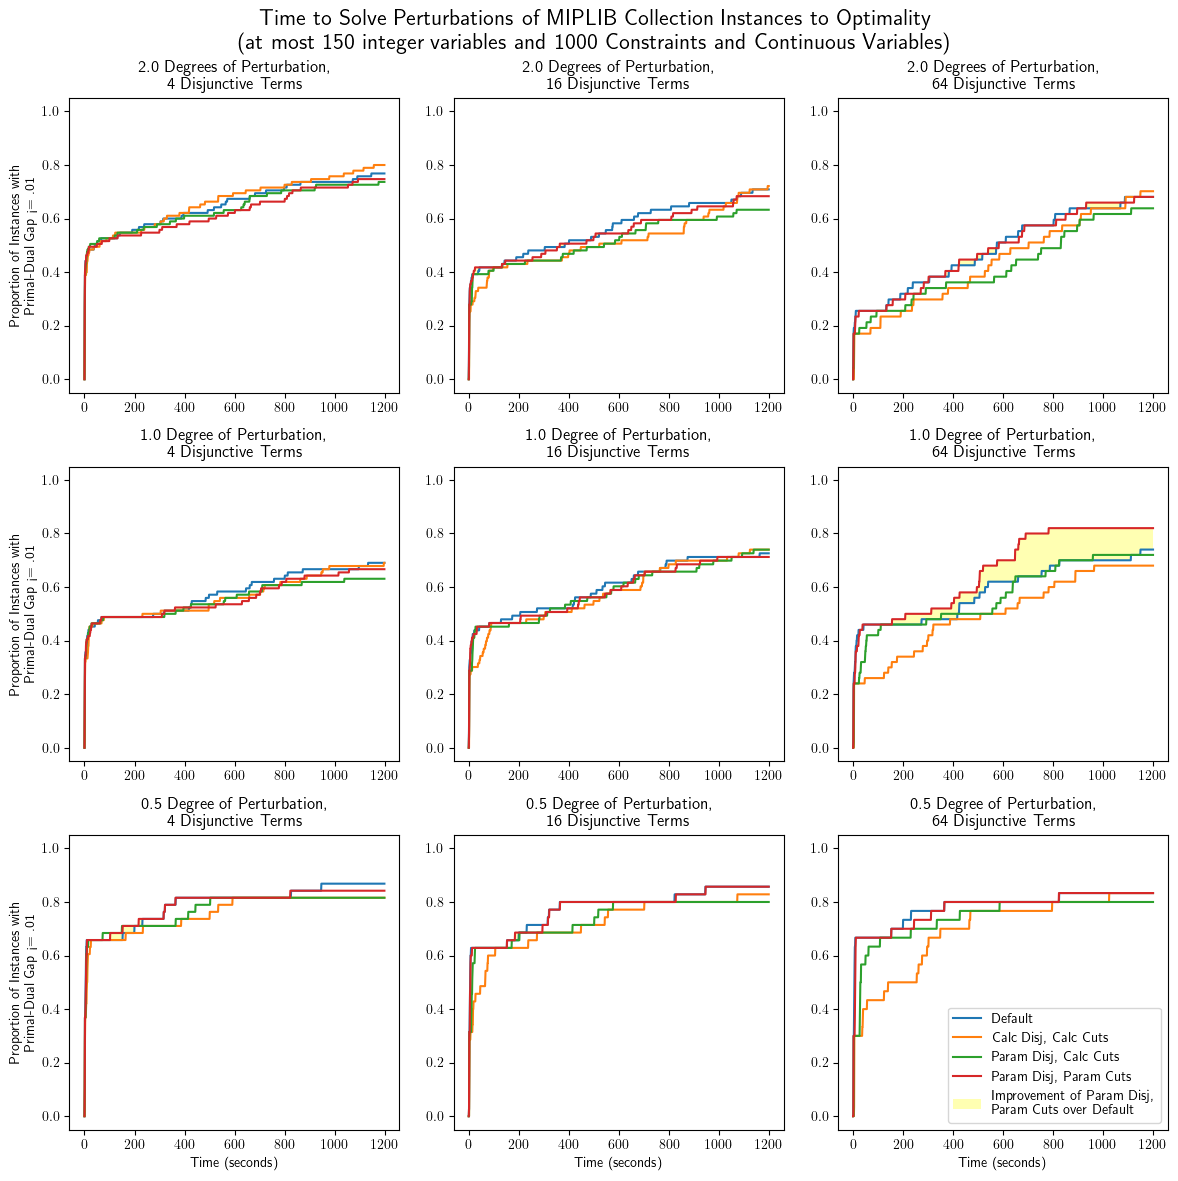

In [200]:
make_plots(time_df, "terminationTime", show_all=True)

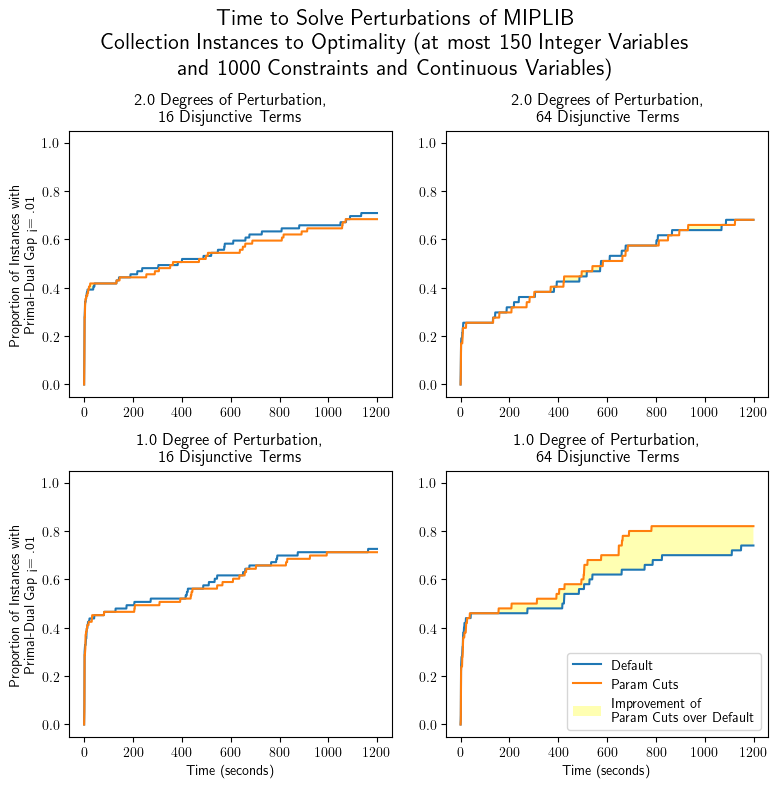

In [194]:
make_plots(time_df, "terminationTime", dim=2)

# Make node table

In [74]:
# additional filtering for dataframe on nodes processed
fields = ["nodes New", "nodes Old", "nodes Farkas",
          "nodes None"]
node_df = df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    node_df[f] = node_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = node_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "node.csv"), index=False, mode="w")
out

,degree,terms,nodes New,nodes Old,nodes Farkas,nodes None,instance,problem number
0,0.5,4,52.917526,52.827737,60.145421,70.706868,5,38
1,0.5,16,55.233057,55.242143,61.716800,76.837000,4,35
2,0.5,64,49.610724,51.111793,50.268000,72.999069,3,29
3,1.0,4,27.818242,29.356379,30.995970,34.098439,9,66
4,1.0,16,31.694344,31.333750,35.974656,39.434031,7,64
5,1.0,64,33.693356,32.929467,34.930778,43.350067,8,45
6,2.0,4,20.678257,21.722054,22.469149,24.028716,10,74
7,2.0,16,33.480426,32.679015,35.208647,37.710162,10,68
8,2.0,64,44.054023,44.444512,49.279860,54.298395,9,43


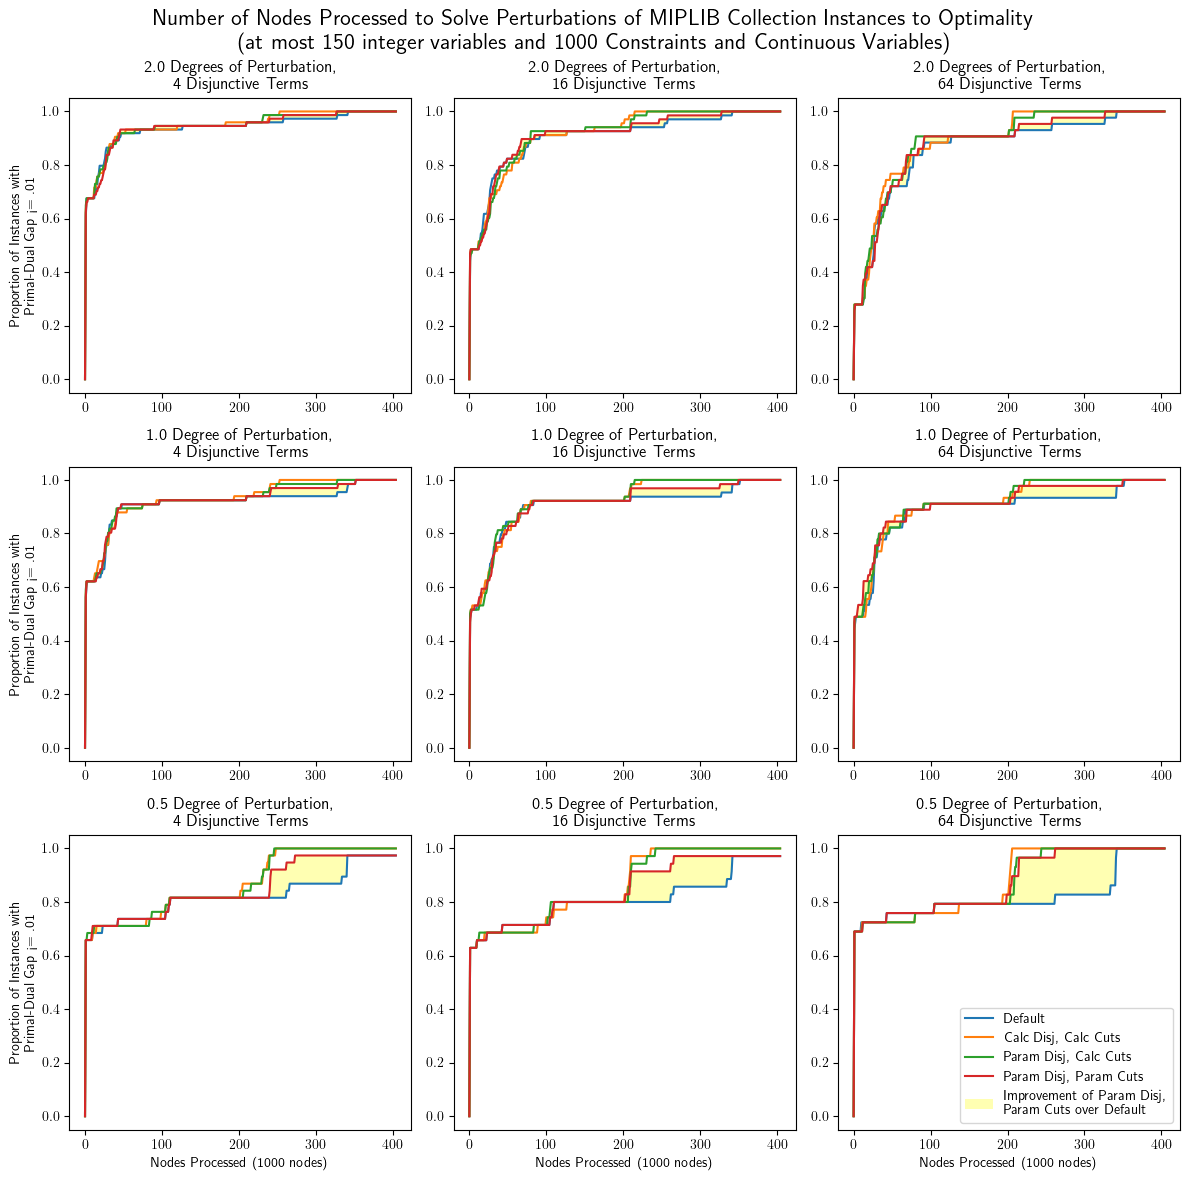

In [201]:
make_plots(node_df, "nodes", show_all=True)

# Make iteration table

In [76]:
# additional filtering for dataframe on nodes processed
fields = ["iterations New", "iterations Old",
          "iterations Farkas", "iterations None"]
iteration_df = df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    iteration_df[f] = iteration_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = iteration_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "iteration.csv"), index=False, mode="w")
out

,degree,terms,iterations New,iterations Old,iterations Farkas,iterations None,instance,problem number
0,0.5,4,309.196158,306.689947,352.998289,421.941342,5,38
1,0.5,16,325.602743,325.887086,365.374486,458.517743,4,35
2,0.5,64,296.114621,309.520034,307.303517,438.677897,3,29
3,1.0,4,232.959136,245.480591,253.213924,276.178182,9,66
4,1.0,16,272.093969,268.896891,290.784500,317.455125,7,64
5,1.0,64,280.391356,286.467600,282.174778,361.392622,8,45
6,2.0,4,177.156541,189.863554,196.596811,198.293243,10,74
7,2.0,16,305.849015,295.264765,317.009750,322.137515,10,68
8,2.0,64,366.762674,376.852605,417.963884,452.754907,9,43


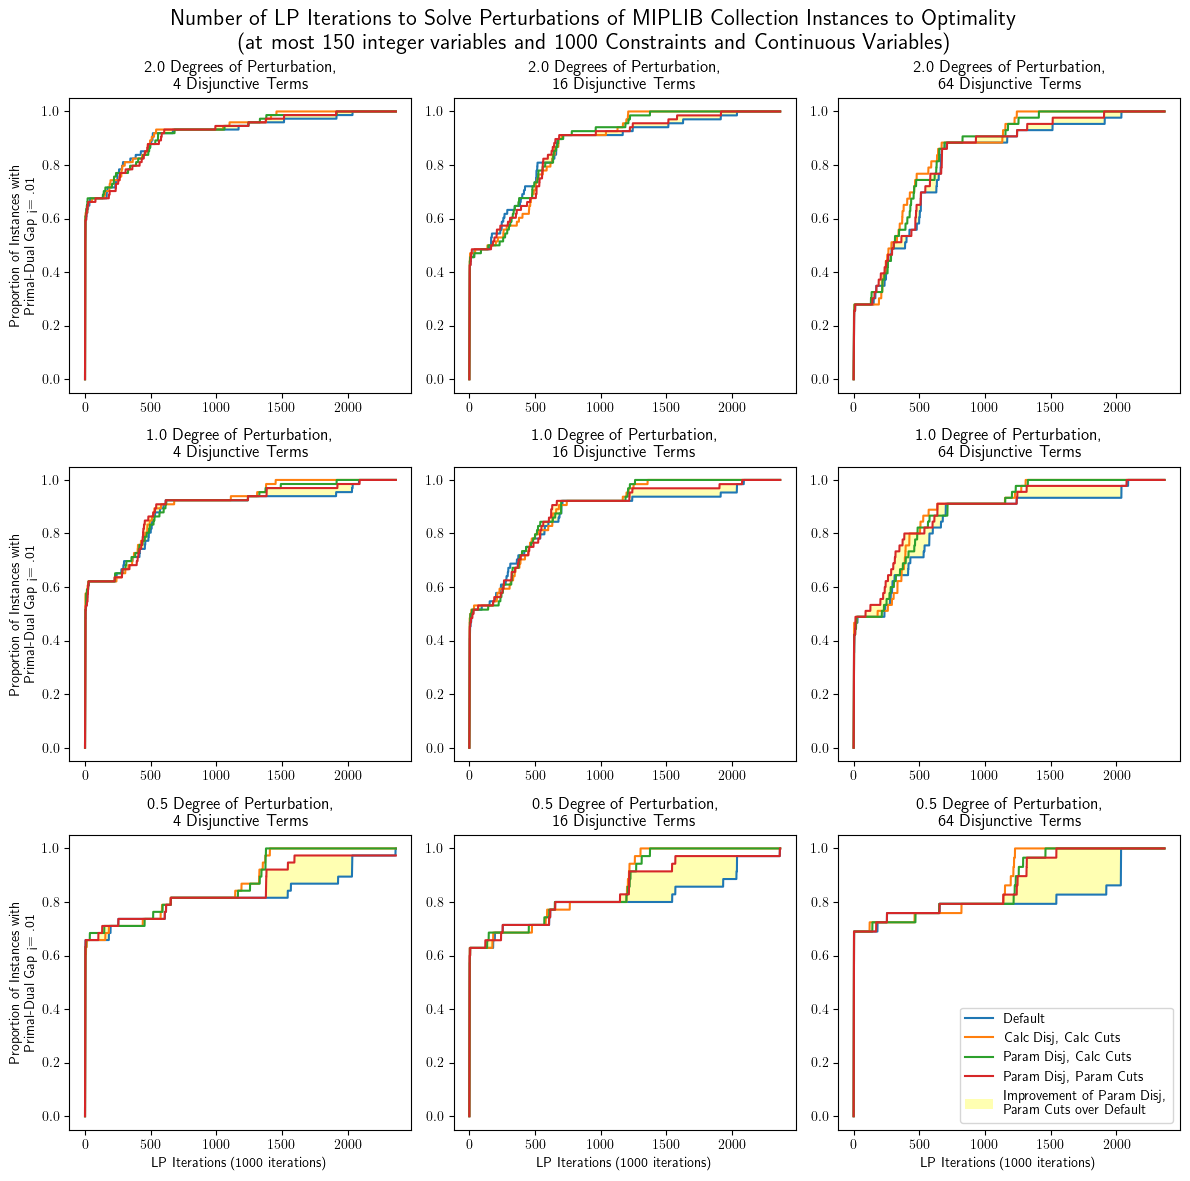

In [202]:
make_plots(iteration_df, "iterations", show_all=True)

In [78]:
gap_map["Farkas"]

,instanceIndex,primalBound,dualBound,times,instance,perturbation,degree,terms
0,0,50.0,46.457140,115,neos-3610051-istra,rhs,1.0,64
1,0,49.0,46.457140,117,neos-3610051-istra,rhs,1.0,64
3,0,49.0,46.457140,119,neos-3610051-istra,rhs,1.0,64
4,0,49.0,46.457140,121,neos-3610051-istra,rhs,1.0,64
5,0,49.0,46.457140,122,neos-3610051-istra,rhs,1.0,64
...,...,...,...,...,...,...,...,...
1272,8,34.0,25.243237,0,bm23,matrix,2.0,4
1330,8,34.0,34.000000,1,bm23,matrix,2.0,4
1441,9,34.0,25.027521,0,bm23,matrix,2.0,4
1481,9,34.0,34.000000,1,bm23,matrix,2.0,4


In [80]:
# join on times so we have a fair comparison - plug in 0s and 1s for the missing values
join_cols = ["instance", "instanceIndex", "perturbation", "degree", "terms", "times"]
gap = gap_map["None"].merge(gap_map["Farkas"], on=join_cols,
                            suffixes=(" None", " Farkas"))

# get the primal dual gap closed by each generator at each time
for gen in ["None", "Farkas"]:
    gap[f"primalDualGap {gen}"] = optimality_gap(gap, gen)

gap

,instanceIndex,primalBound None,dualBound None,times,instance,perturbation,degree,terms,primalBound Farkas,dualBound Farkas,primalDualGap None,primalDualGap Farkas
0,0,12912.475382,10482.795280,36,mas74,matrix,2.0,64,12912.475382,10658.658628,0.188165,0.174546
1,0,12912.475382,10482.795280,37,mas74,matrix,2.0,64,12912.475382,10658.658628,0.188165,0.174546
2,0,12912.475382,10482.795280,39,mas74,matrix,2.0,64,12912.475382,10658.658628,0.188165,0.174546
3,0,12912.475382,10482.795280,40,mas74,matrix,2.0,64,12912.475382,10658.658628,0.188165,0.174546
4,0,12912.475382,10482.795280,41,mas74,matrix,2.0,64,12001.167086,10658.658628,0.188165,0.111865
...,...,...,...,...,...,...,...,...,...,...,...,...
409105,6,149.000000,147.225442,539,neos-3610173-itata,rhs,2.0,16,149.000000,146.522318,0.011910,0.016629
409106,6,149.000000,147.232762,541,neos-3610173-itata,rhs,2.0,16,149.000000,146.527483,0.011861,0.016594
409107,6,149.000000,147.233966,543,neos-3610173-itata,rhs,2.0,16,149.000000,146.529620,0.011853,0.016580
409108,6,149.000000,147.233966,544,neos-3610173-itata,rhs,2.0,16,149.000000,146.534971,0.011853,0.016544


In [83]:
gb = gap.groupby(["degree", "terms", "times"]).agg({"primalDualGap None": "mean", "primalDualGap Farkas": "mean"}).reset_index()
gb

,degree,terms,times,primalDualGap None,primalDualGap Farkas
0,0.5,4,0,0.130054,0.131564
1,0.5,4,1,0.125822,0.118971
2,0.5,4,2,0.237925,0.221184
3,0.5,4,3,0.139720,0.126178
4,0.5,4,4,0.165293,0.153035
...,...,...,...,...,...
10877,2.0,64,1199,0.041832,0.043105
10878,2.0,64,1200,0.071876,0.076660
10879,2.0,64,1201,0.083051,0.086302
10880,2.0,64,1202,0.099225,0.107568


In [ ]:
# todo: have data collection fill in primal dual of 1 0 each second until first reading
# todo: have data collection fill in primal dual of 1 1 each from last second until time reading
# todo: have data collection take latest reading each second and drop down readings when none is available
# todo: take average of primal-dual gap at each second

# Create subplots for a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Unique values in 'degree' and 'terms'
unique_degrees = gb['degree'].unique()
unique_terms = gb['terms'].unique()

for i, degree in enumerate(unique_degrees):
    for j, terms in enumerate(unique_terms):
        ax = axes[i, j]

        # Filter the DataFrame based on 'degree' and 'terms'
        subset_df = gb[(gb['degree'] == degree) & (gb['terms'] == terms)]        
        
        # get our data
        x = range(int(gb[[f"{metric} Farkas", f"{metric} None"]].max().max()))
        y_farkas = [(subset_df[f"{metric} Farkas"] < i).sum() / len(subset_df) for i in x]        
        y_none = [(subset_df[f"{metric} None"] < i).sum() / len(subset_df) for i in x]
        
        # make our plot
        ax.plot(x, y_farkas, label="Parameterized VPCs")
        ax.plot(x, y_none, label="No VPCs")
        
        # Highlight the region where Farkas VPCs have solved more instances than None
        fill_region = np.array([y_farkas[i] > y_none[i] for i in x])
        ax.fill_between(x, y_none, y_farkas, facecolor='yellow', alpha=0.3, where=fill_region, label="Improvement from\nParameterized VPCs")
        
        if j == 0:
            ax.set_ylabel("Proportion of Instances with\nPrimal-Dual Gap <= .01")
        if i == 2:
            ax.set_xlabel(label[metric])
        ax.set_title(f"{degree} Degree{'s' if degree >= 2 else ''}, {terms} Terms")

plt.tight_layout()
plt.legend()
plt.show()